In [1]:
import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb
matplotlib.style.use('ggplot')
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [3]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [4]:
cursor.execute('Select * from "ahshouseholdclass2"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [26]:
df = pd.read_csv('AHS Household Class.csv')

In [27]:
df.head()

,Unnamed: 0,CONTROL,YEAR,RATINGHS_BIN,RATINGHS,STORIES,UFINROOMS,BEDROOMS,HHOLDKIDS,KITCHENS,...,OWNLOT,WINBARS,KITCHSINK,GARAGE,HHSEE,HHERRND,FIRSTHOME,WASHER,DISHWASH,HHSEX
0,0,11000006,2017,extremely satisfied,10,1.0,0.0,3.0,0.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
1,3,11000023,2017,satisfied,8,3.0,0.0,3.0,0.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
2,4,11000046,2017,extremely satisfied,10,1.0,0.0,3.0,3.0,1.0,...,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
3,5,11000048,2017,very satisfied,9,3.0,0.0,4.0,2.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0
4,6,11000052,2017,not satisfied,5,2.0,0.0,4.0,0.0,1.0,...,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20108 entries, 0 to 20107
Data columns (total 82 columns):
Unnamed: 0      20108 non-null int64
CONTROL         20108 non-null int64
YEAR            20108 non-null int64
RATINGHS_BIN    20108 non-null object
RATINGHS        20108 non-null int64
STORIES         20108 non-null float64
UFINROOMS       20108 non-null float64
BEDROOMS        20108 non-null float64
HHOLDKIDS       20108 non-null float64
KITCHENS        20108 non-null float64
ELECAMT         20108 non-null float64
HHADLTKIDS      20108 non-null float64
FINROOMS        20108 non-null float64
NUMVETS         20108 non-null float64
HHMOVE          20108 non-null float64
NUMOLDKIDS      20108 non-null float64
TRASHAMT        20108 non-null float64
WATERAMT        20108 non-null float64
FINCP           20108 non-null float64
BATHROOMS       20108 non-null float64
NUMSUBFAM       20108 non-null float64
NUMSECFAM       20108 non-null float64
UNITSIZE        20108 non-null float64
NUM

In [29]:
df.describe()

,Unnamed: 0,CONTROL,YEAR,RATINGHS,STORIES,UFINROOMS,BEDROOMS,HHOLDKIDS,KITCHENS,ELECAMT,...,OWNLOT,WINBARS,KITCHSINK,GARAGE,HHSEE,HHERRND,FIRSTHOME,WASHER,DISHWASH,HHSEX
count,20108.000000,2.010800e+04,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,...,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.000000,20108.0,20108.000000,20108.000000,20108.000000
mean,14591.124776,1.104341e+07,2015.945494,8.393127,1.796002,0.021832,2.978267,0.345087,1.000497,119.455441,...,1.040581,1.951611,1.002934,1.295653,1.966730,1.953601,1.0,1.055998,1.341755,1.493982
std,8328.560259,2.481080e+04,0.998538,1.612839,0.947553,0.183550,0.801398,0.762960,0.037314,60.538925,...,0.197322,0.214592,0.054090,0.456347,0.179346,0.210354,0.0,0.229923,0.474310,0.499976
min,0.000000,1.100001e+07,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
25%,7416.750000,1.102198e+07,2015.000000,8.000000,1.000000,0.000000,3.000000,0.000000,1.000000,80.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.0,1.000000,1.000000,1.000000
50%,14681.500000,1.104361e+07,2015.000000,8.000000,2.000000,0.000000,3.000000,0.000000,1.000000,110.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.0,1.000000,1.000000,1.000000
75%,21873.750000,1.106504e+07,2017.000000,10.000000,2.000000,0.000000,3.000000,0.000000,1.000000,150.000000,...,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.0,1.000000,2.000000,2.000000
max,28803.000000,1.108700e+07,2017.000000,10.000000,7.000000,5.000000,5.000000,7.000000,2.000000,450.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,2.000000,2.000000


In [30]:
df.columns

Index(['Unnamed: 0', 'CONTROL', 'YEAR', 'RATINGHS_BIN', 'RATINGHS', 'STORIES',
       'UFINROOMS', 'BEDROOMS', 'HHOLDKIDS', 'KITCHENS', 'ELECAMT',
       'HHADLTKIDS', 'FINROOMS', 'NUMVETS', 'HHMOVE', 'NUMOLDKIDS', 'TRASHAMT',
       'WATERAMT', 'FINCP', 'BATHROOMS', 'NUMSUBFAM', 'NUMSECFAM', 'UNITSIZE',
       'NUMADULTS', 'HHYNGKIDS', 'UTILAMT', 'NUMELDERS', 'NUMYNGKIDS',
       'NUMPEOPLE', 'OTHERAMT', 'HINCP', 'PARTNER', 'PERPOVLVL', 'LOTSIZE',
       'TOTROOMS', 'HHAGE', 'LAUNDY', 'NUMNONREL', 'MULTIGEN', 'OILAMT',
       'GASAMT', 'DINING', 'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN',
       'NUMERRND', 'OMB13CBSA', 'MVG1COST', 'HHRACE', 'NUMHEAR', 'NUMWALK',
       'MVG2COST', 'MVG3COST', 'HSHLDTYPE', 'FIREPLACE', 'NUMCARE', 'HHMAR',
       'HHNATVTY', 'BLD', 'NUMMEMRY', 'MILHH', 'COOKFUEL', 'DIVISION',
       'NUMSEE', 'HHCARE', 'CONDO', 'FRIDGE', 'HHMEMRY', 'HHWALK', 'HHHEAR',
       'NOSTEP', 'OWNLOT', 'WINBARS', 'KITCHSINK', 'GARAGE', 'HHSEE',
       'HHERRND', 'FIRSTHO

In [31]:
target = df['RATINGHS_BIN']

In [32]:
#df= df.drop(['RATINGHS_BIN','LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN'], axis=1)

In [33]:
#identify  any null values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [34]:
# Change the data type to int32
df.astype('int32').dtypes

ValueError: invalid literal for int() with base 10: 'extremely satisfied'

In [88]:
#df['HINCP'].hist()

## Distribution 

In [35]:
matplotlib.style.use('ggplot')

In [36]:
df_Kitch = df[['LAUNDY', 'COOKFUEL', 'DIVISION', 'FIREPLACE', 'FRIDGE', 'HHCARE', 'NOSTEP', 'WASHER', 'HHSEE',
       'KITCHSINK', 'HHERRND', 'WINBARS','GARAGE', 'DISHWASH']]

In [37]:
df_move = df[['HHYNGKIDS', 'HHMOVE', 'HHOLDKIDS',
       'HHRACE', 'OMB13CBSA','HHMAR', 'HHNATVTY', 'HHCARE', 'NOSTEP', 'HHSEE', 'HHERRND', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c31da3e48>,
      dtype=object)

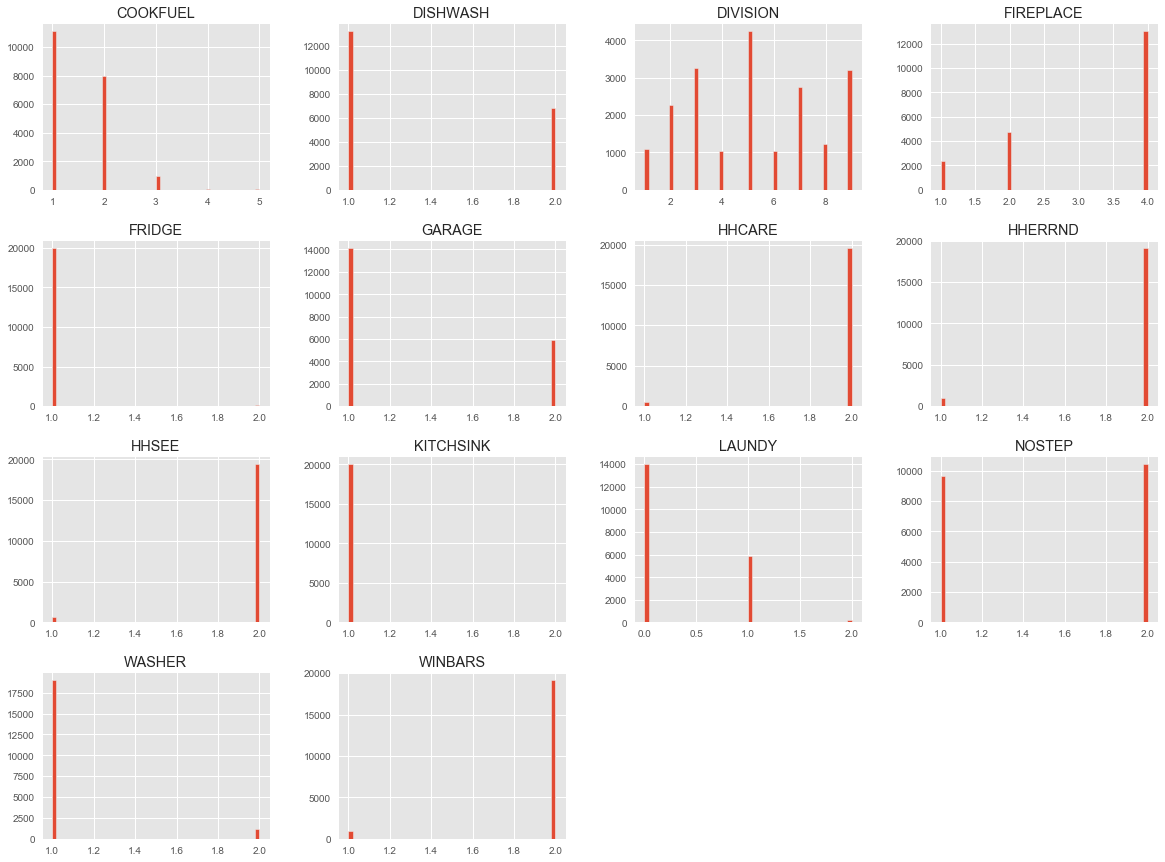

In [38]:
df_Kitch.hist(bins=50, figsize=(20,15))

##### Washer, HHSEE, HHCARE,Fridge and Kitchsink have only Yes values - do we need this feature for our model


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2f21ae48>,
      dtype=object)

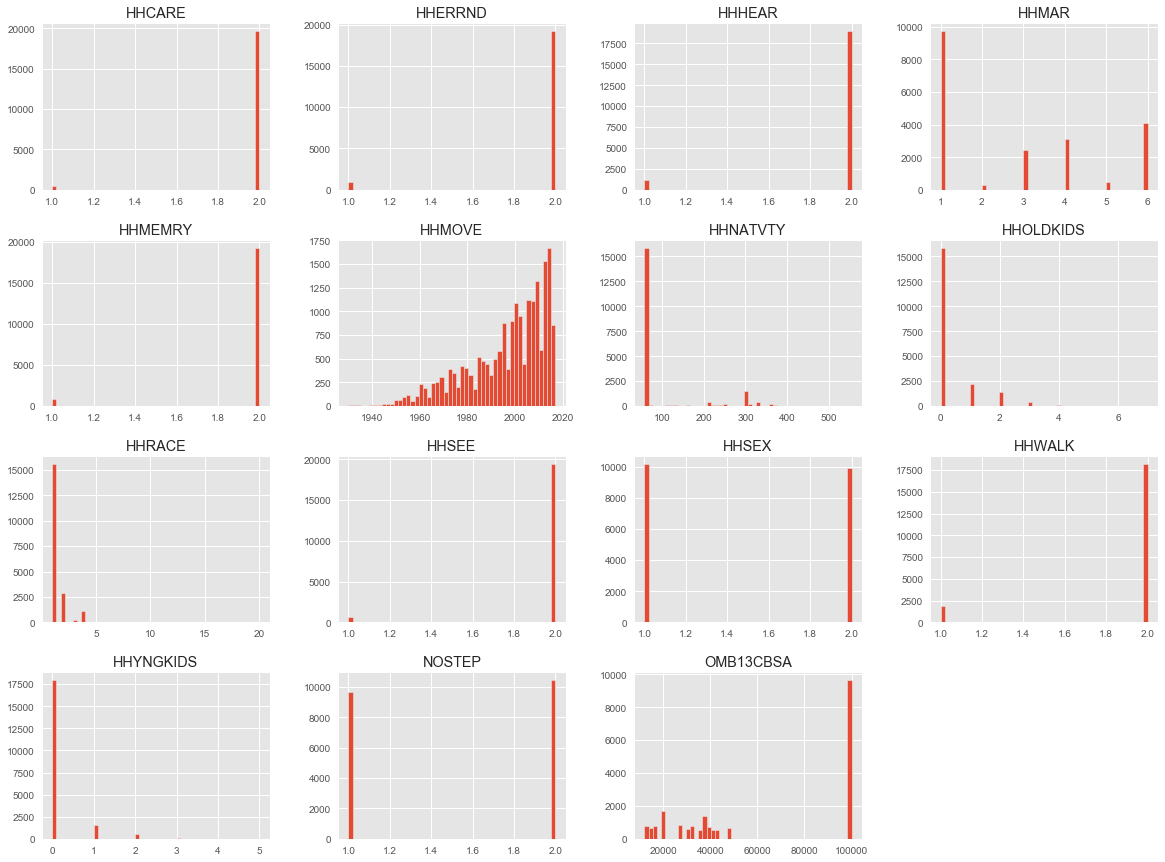

In [20]:
df_move.hist(bins=50, figsize=(20,15))

#### Remove HHCARE, HHSEE, HHMEMRY, HHEAR, HHERRAND,  HHWALK, HHHEAR, HHYNGKIDS

#### Seem like every unit has one kitchen - should we drop this feature?



####  should we drop few features?


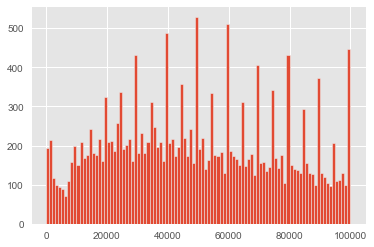

In [39]:
#Household Income (past 12 months)
df['HINCP'].hist(bins=100)

In [40]:
#Transform the income from year to monthly
df['HINCP']= df['HINCP'].divide(12)
df['HINCP']

0        4891.666667
1        8333.333333
2        1250.000000
3        8333.333333
4        1100.000000
            ...     
20103    1083.333333
20104    3916.666667
20105    7500.000000
20106     166.666667
20107    1500.000000
Name: HINCP, Length: 20108, dtype: float64

In [41]:
#Correlation with target to other features
corr_matrix = df.corr()
corr_matrix['RATINGHS'].sort_values(ascending=False)

RATINGHS     1.000000
BATHROOMS    0.122283
UNITSIZE     0.122050
NUMELDERS    0.120224
TOTROOMS     0.117428
               ...   
FIREPLACE   -0.084583
HHMOVE      -0.092285
GARAGE      -0.092718
DISHWASH    -0.102172
FIRSTHOME         NaN
Name: RATINGHS, Length: 79, dtype: float64

In [44]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
#attributes = ['RATINGHS', 'HINCP', 'UNITSIZE', 'BEDROOMS', 'BLD' ]
attributes = ['RATINGHS_BIN', 'BEDROOMS', 'STORIES',
       'PERPOVLVL', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE',
       'UFINROOMS', 'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM',
       'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT',
       'TOTROOMS', 'BATHROOMS', 'NUMYNGKIDS',
       'TRASHAMT', 'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT',
       'ELECAMT', 'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS',
       'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN', 'NUMCARE', 'NUMWALK',
       'HHRACE', 'OMB13CBSA']
scatter_matrix(df[attributes], alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a1c778ea0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1a1c9dee18> (for post_execute):


KeyboardInterrupt: 

In [87]:
df_f = df[['RATINGHS_BIN', 'BEDROOMS', 'STORIES',
       'PERPOVLVL', 'HHADLTKIDS', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE',
       'UFINROOMS', 'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM',
       'OILAMT', 'DINING', 'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT',
       'TOTROOMS', 'BATHROOMS', 'NUMYNGKIDS',
       'TRASHAMT', 'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT',
       'ELECAMT', 'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS',
       'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN', 'NUMCARE', 'NUMWALK',
       'HHRACE', 'OMB13CBSA', 'HSHLDTYPE', 'MVG3COST', 'MVG2COST', 'MILHH',
       'HHMAR', 'HHNATVTY', 'COOKFUEL', 'NUMMEMRY', 'NUMSEE',
       'BLD', 'NUMHEAR', 'MVG1COST', 'DIVISION', 'CONDO',
       'OWNLOT', 'FIRSTHOME', 'NOSTEP',  'GARAGE', 'DISHWASH']]

### Run the correlation again

In [36]:
corr_matrix = df.corr()
corr_matrix['RATINGHS'].sort_values(ascending=False)

RATINGHS     1.000000
BATHROOMS    0.122283
UNITSIZE     0.122050
NUMELDERS    0.120224
TOTROOMS     0.117428
               ...   
FIREPLACE   -0.084583
HHMOVE      -0.092285
GARAGE      -0.092718
DISHWASH    -0.102172
FIRSTHOME         NaN
Name: RATINGHS, Length: 77, dtype: float64

In [37]:
df_cof = df[['RATINGHS','PERPOVLVL', 'NUMELDERS','BEDROOMS','OMB13CBSA','TOTROOMS','BATHROOMS', 'HHMOVE', 'UTILAMT','HHNATVTY','HINCP','FINCP']]

In [38]:
corr_matrix = df_1.corr()
corr_matrix['RATINGHS'].sort_values(ascending=False)

RATINGHS     1.000000
TOTROOMS     0.117428
LOTSIZE      0.063994
DINING       0.048323
HHMEMRY      0.039707
LAUNDY       0.034716
HHWALK       0.028703
HHERRND      0.028554
HINCP        0.026388
HHSEX        0.023194
WINBARS      0.020766
STORIES      0.017886
UFINROOMS    0.002422
HHHEAR      -0.005263
FRIDGE      -0.012919
COOKFUEL    -0.023987
KITCHSINK   -0.027475
FIREPLACE   -0.084583
GARAGE      -0.092718
DISHWASH    -0.102172
Name: RATINGHS, dtype: float64

 ### Rank-by-feature

To visualize the correlation matrix for your features

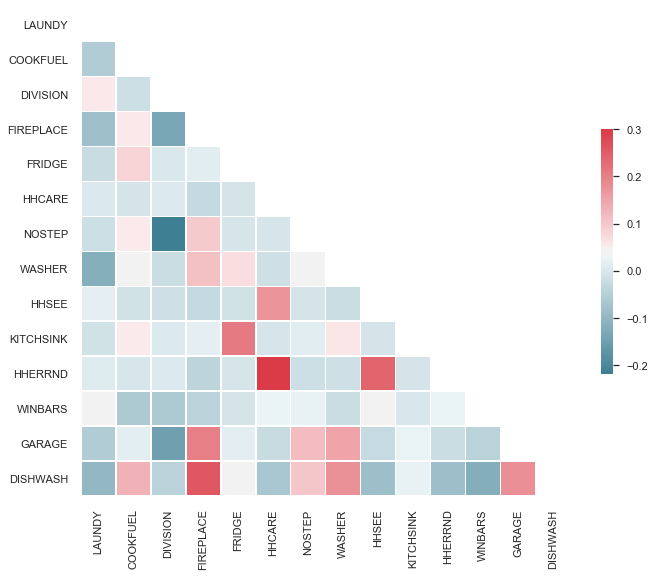

In [45]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df_Kitch.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

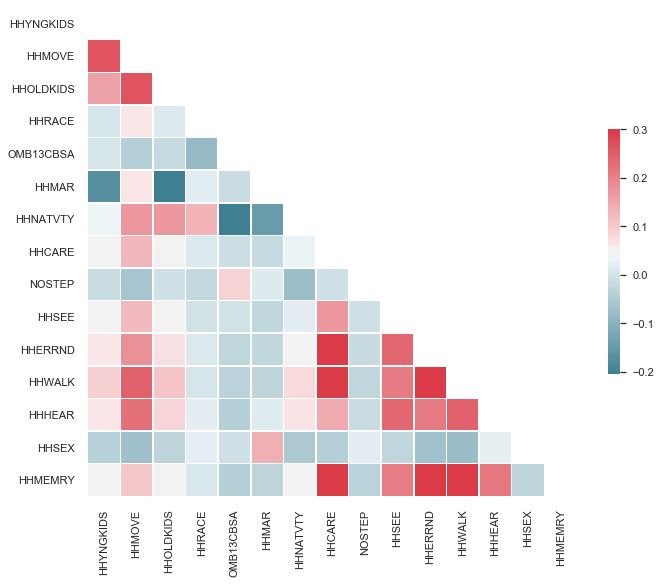

In [46]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df_move.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Remove HHCARE, HHSEE, HHMEMRY, HHEAR, HHERRAND,  HHWALK,'NUMYNGKIDS', HHHEAR, HHYNGKIDS,Washer, HHSEE, HHCARE,Fridge and Kitchsink -- do we need this feature for our model

In [47]:
# Will drop features ELECAMT', 'GASAMT', 'OILAMT', 'OTHERAMT','TRASHAMT', 'WATERAMT' and Keep only utilamount 
df = df.drop(columns=['Unnamed: 0', 'CONTROL', 'YEAR', 
       'HHADLTKIDS', 'NUMYNGKIDS',
       'HHCARE', 'FRIDGE', 'HHMEMRY', 'HHWALK', 'HHHEAR',
       'KITCHSINK', 'HHSEE',
       'HHERRND', 'FIRSTHOME', 'WASHER'])



In [48]:
df.columns

Index(['RATINGHS_BIN', 'RATINGHS', 'STORIES', 'UFINROOMS', 'BEDROOMS',
       'HHOLDKIDS', 'KITCHENS', 'ELECAMT', 'FINROOMS', 'NUMVETS', 'HHMOVE',
       'NUMOLDKIDS', 'TRASHAMT', 'WATERAMT', 'FINCP', 'BATHROOMS', 'NUMSUBFAM',
       'NUMSECFAM', 'UNITSIZE', 'NUMADULTS', 'HHYNGKIDS', 'UTILAMT',
       'NUMELDERS', 'NUMPEOPLE', 'OTHERAMT', 'HINCP', 'PARTNER', 'PERPOVLVL',
       'LOTSIZE', 'TOTROOMS', 'HHAGE', 'LAUNDY', 'NUMNONREL', 'MULTIGEN',
       'OILAMT', 'GASAMT', 'DINING', 'LN_HINCP', 'LN_FINCP', 'HINCP_BIN',
       'FINCP_BIN', 'NUMERRND', 'OMB13CBSA', 'MVG1COST', 'HHRACE', 'NUMHEAR',
       'NUMWALK', 'MVG2COST', 'MVG3COST', 'HSHLDTYPE', 'FIREPLACE', 'NUMCARE',
       'HHMAR', 'HHNATVTY', 'BLD', 'NUMMEMRY', 'MILHH', 'COOKFUEL', 'DIVISION',
       'NUMSEE', 'CONDO', 'NOSTEP', 'OWNLOT', 'WINBARS', 'GARAGE', 'DISHWASH',
       'HHSEX'],
      dtype='object')

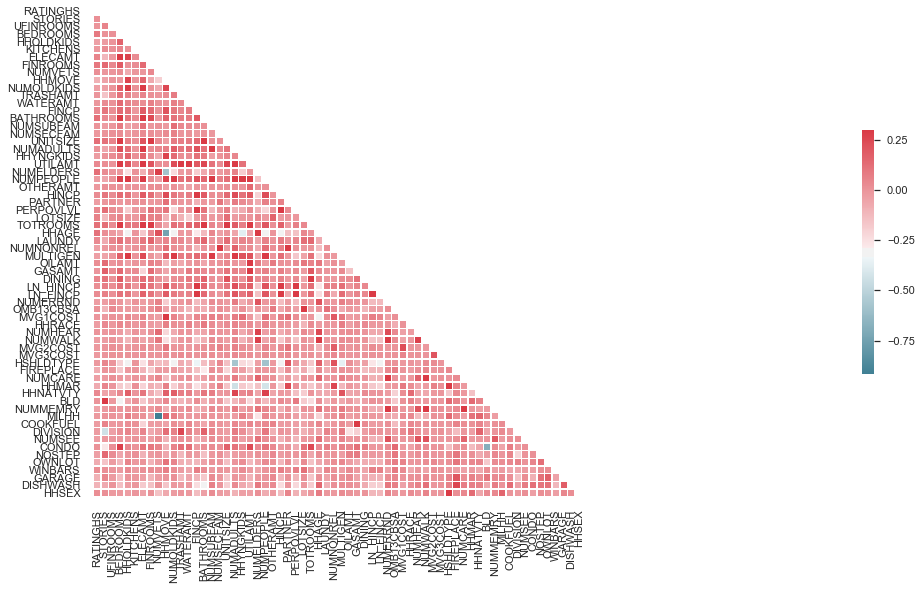

In [54]:
from string import ascii_letters as letters
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(100, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, 
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Balanced Binning

In [55]:
from yellowbrick.datasets import load_concrete
from yellowbrick.target import BalancedBinningReference


# Instantiate the visualizer
visualizer = BalancedBinningReference(bins=[0,7,8,9,10])

y = df_sub['RATINGHS']
visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

NameError: name 'df_sub' is not defined

In [138]:
df = df[[c for c in df if c not in ['RATINGHS']] + ['RATINGHS']]


In [139]:
labels = df['RATINGHS']

## Feature Analysis


In [69]:


LABEL_MAP = {
    1: "Un-Satisfied",
    2: "Un-Satisfied",
    3: "Un-Satisfied",
    4: "Un-Satisfied",
    5: "Un-Satisfied",
    6: "Un-Satisfied",
    7: "Satisfied",
    8: "Satisfied",
    9: "Highly Satisfied",
    10: "Extreme Satisfied"
}

# Convert class labels into text
y = df['RATINGHS'].map(LABEL_MAP)


In [70]:
#df_sub['RATINGHS'] = df_sub['RATINGHS'].astype(str)
#df['RATINGHS']
y

0        Extreme Satisfied
1                Satisfied
2        Extreme Satisfied
3         Highly Satisfied
4             Un-Satisfied
               ...        
20103            Satisfied
20104            Satisfied
20105    Extreme Satisfied
20106            Satisfied
20107     Highly Satisfied
Name: RATINGHS, Length: 20108, dtype: object

In [80]:
# Extract our X and y data

X = df[['PERPOVLVL','BEDROOMS','OMB13CBSA','ELECAMT','BATHROOMS',
       'UTILAMT', 'UNITSIZE', 'HHNATVTY', 'HINCP', 'HHSEX',
       'GARAGE', 'DISHWASH','DINING', 'LAUNDY']].values
#y = df['RATINGHS_BIN'].values

### Encode our target variable

In [78]:
from sklearn.preprocessing import LabelEncoder
# Encode our target variable

encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

y

array([0, 2, 0, ..., 0, 2, 1])

In [79]:
print(X.shape, y.shape)

(20108, 67) (20108,)


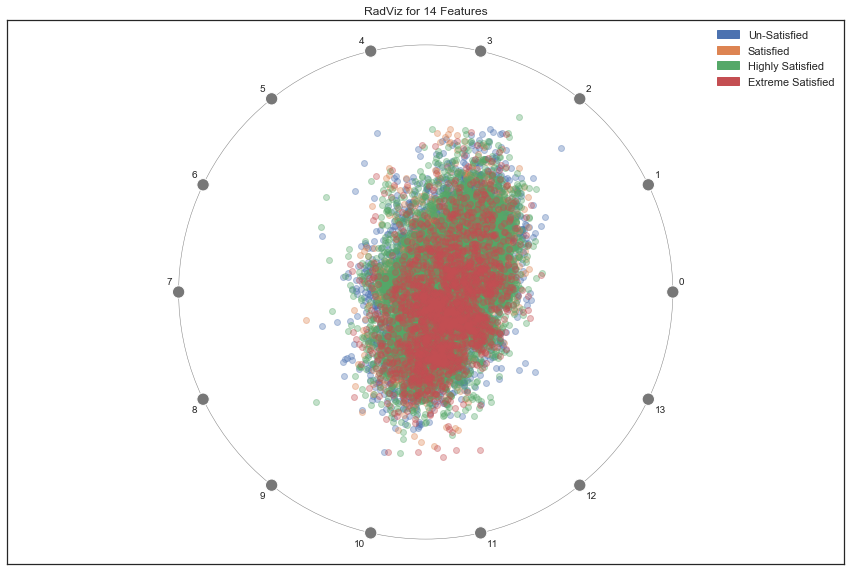

In [75]:
from yellowbrick.features import RadViz
classes = ["Un-Satisfied", "Satisfied","Highly Satisfied","Extreme Satisfied"]

_ = RadViz(size=(1080, 720),classes=classes, alpha=0.35).fit_transform_show(X, y)

## Parallel Coordinates


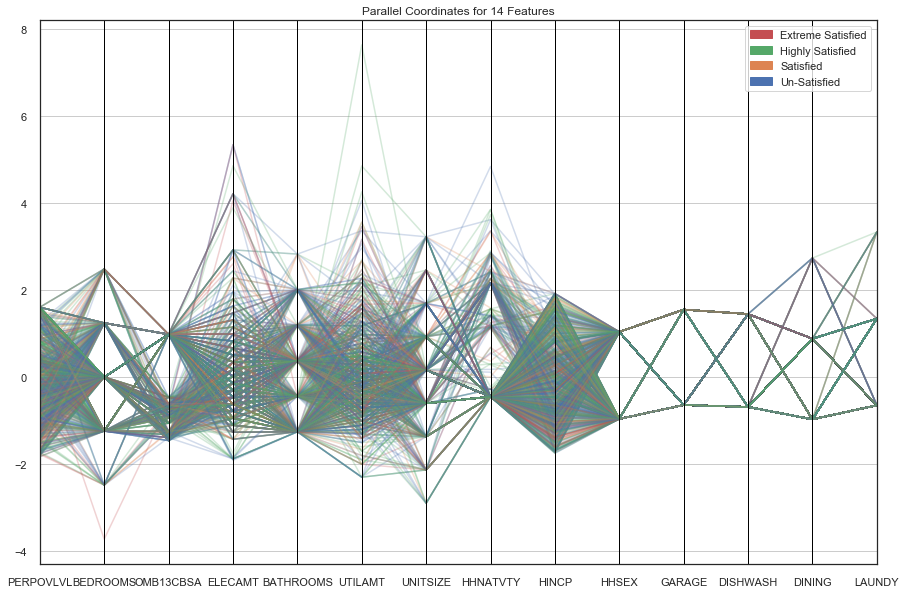

In [81]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    'PERPOVLVL','BEDROOMS','OMB13CBSA','ELECAMT','BATHROOMS',
       'UTILAMT', 'UNITSIZE', 'HHNATVTY', 'HINCP', 'HHSEX',
       'GARAGE', 'DISHWASH','DINING', 'LAUNDY'
]
classes = ["Un-Satisfied", "Satisfied","Highly Satisfied","Extreme Satisfied"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', 
    sample=0.05, shuffle=True, size=(1080, 720)
)

# Fit the visualizer and display it
visualizer.fit(X, y)
visualizer.transform(X)

visualizer.show()

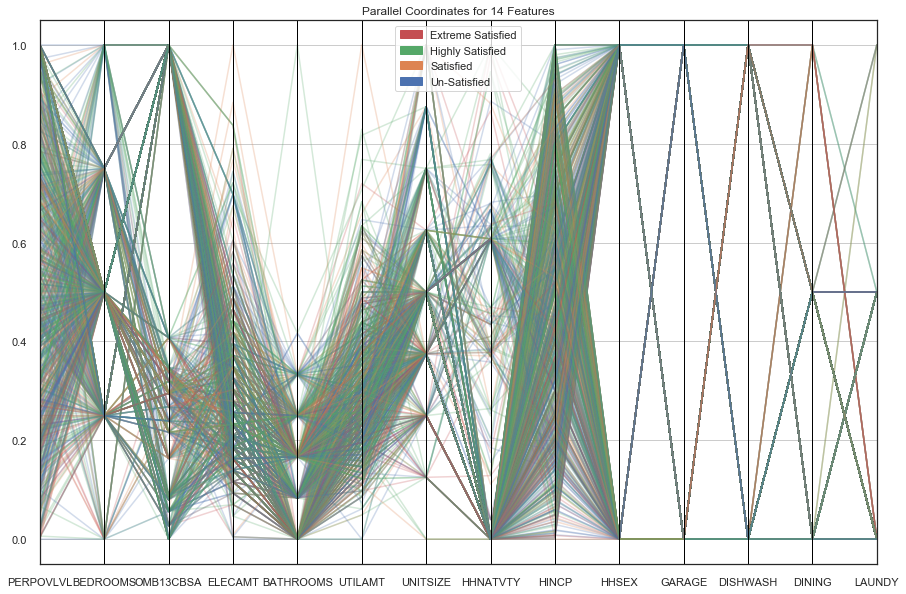

In [83]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    'PERPOVLVL','BEDROOMS','OMB13CBSA','ELECAMT','BATHROOMS',
       'UTILAMT', 'UNITSIZE', 'HHNATVTY', 'HINCP', 'HHSEX',
       'GARAGE', 'DISHWASH','DINING', 'LAUNDY'
]
classes = ["Un-Satisfied", "Satisfied","Highly Satisfied","Extreme Satisfied"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='minmax', 
    sample=0.05, shuffle=True, size=(1080, 720)
)

# Fit the visualizer and display it
visualizer.fit(X, y)
visualizer.transform(X)

visualizer.show()

## Feature Importance

In [84]:
#df = df[[c for c in df if c not in ['RATINGHS']] + ['RATINGHS']]
y

array([0, 2, 0, ..., 0, 2, 1])

In [89]:

y = df['RATINGHS']
X = df.drop(['RATINGHS', 'RATINGHS_BIN', 'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN'], axis=1)



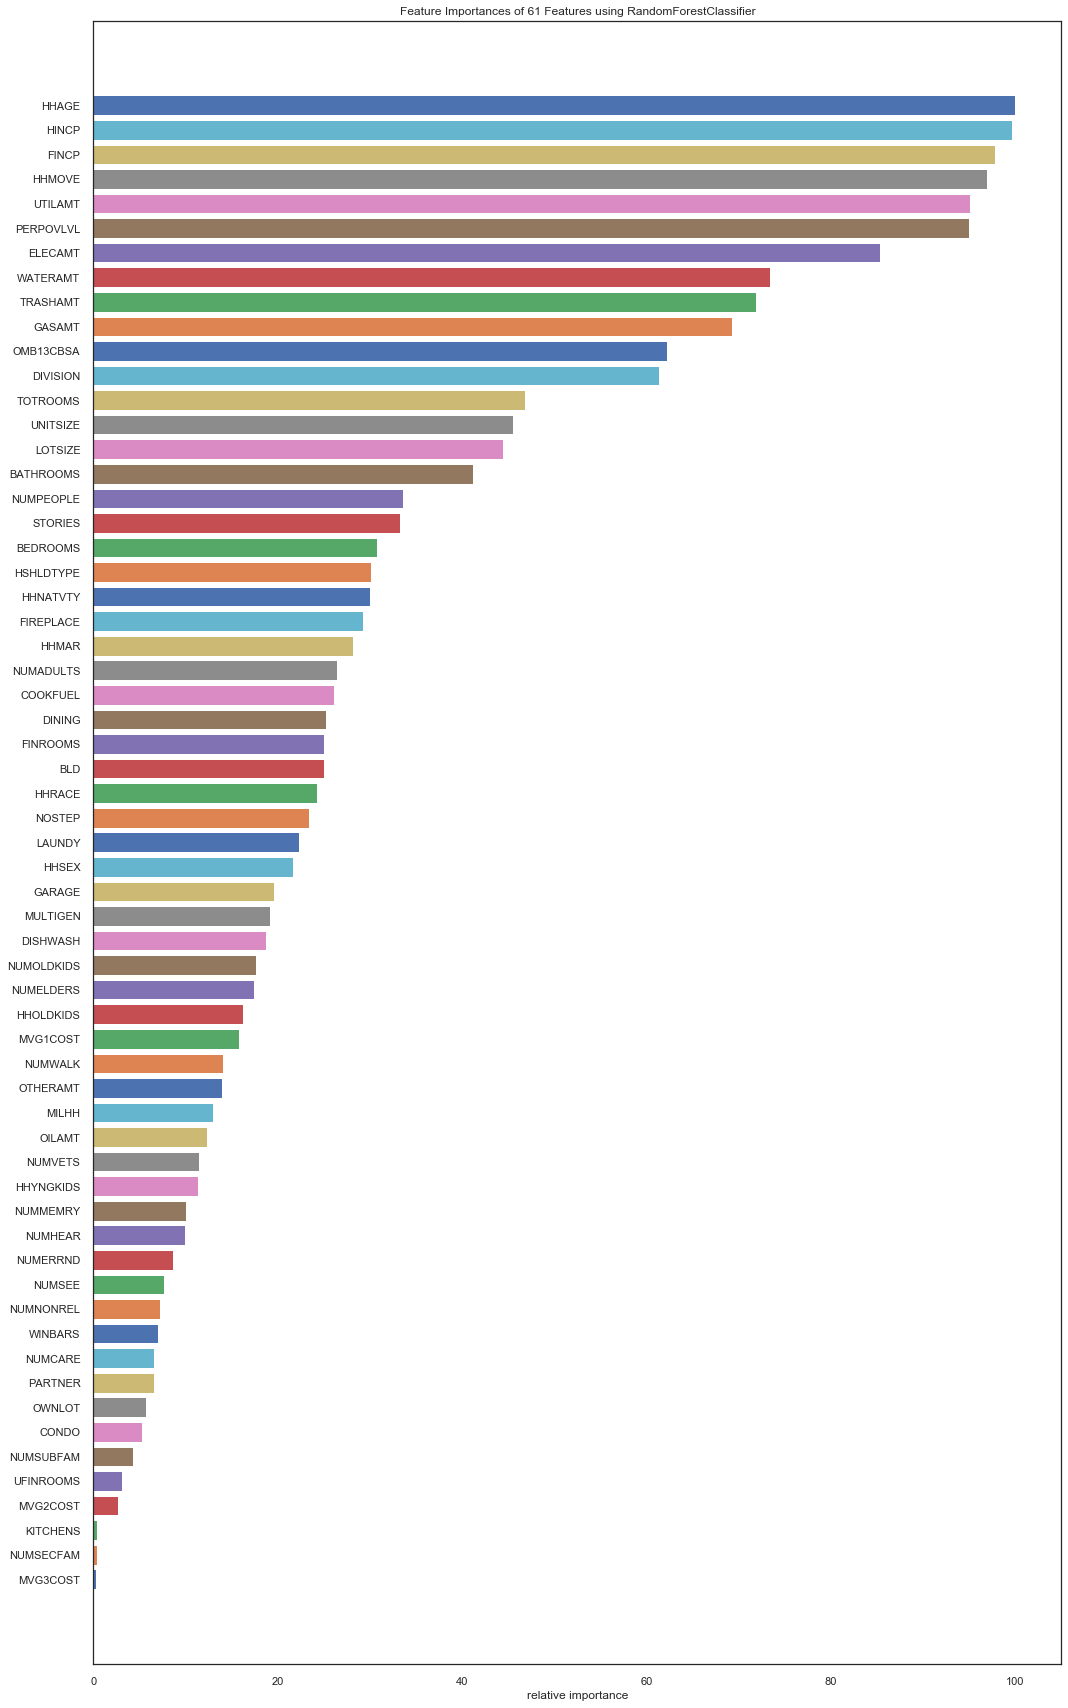

In [90]:
#Using Randomforest classifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(1080, 1720))

viz.fit(X, y)
viz.show()

In [103]:
# Create a dictionary that will map the feature name with its feature importance
'''
feats = {}

# Loop through Feature
for feature, importance in zip(X.columns, model.feature_importances_):
    feats[feature] = importance # Add the name/value pair

# View our dictionary, but sorted in order of importance
sorted(feats.items(), key=lambda x: x[1], reverse=True)
'''

'\nfeats = {}\n\n# Loop through Feature\nfor feature, importance in zip(X.columns, model.feature_importances_):\n    feats[feature] = importance # Add the name/value pair\n\n# View our dictionary, but sorted in order of importance\nsorted(feats.items(), key=lambda x: x[1], reverse=True)\n'

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


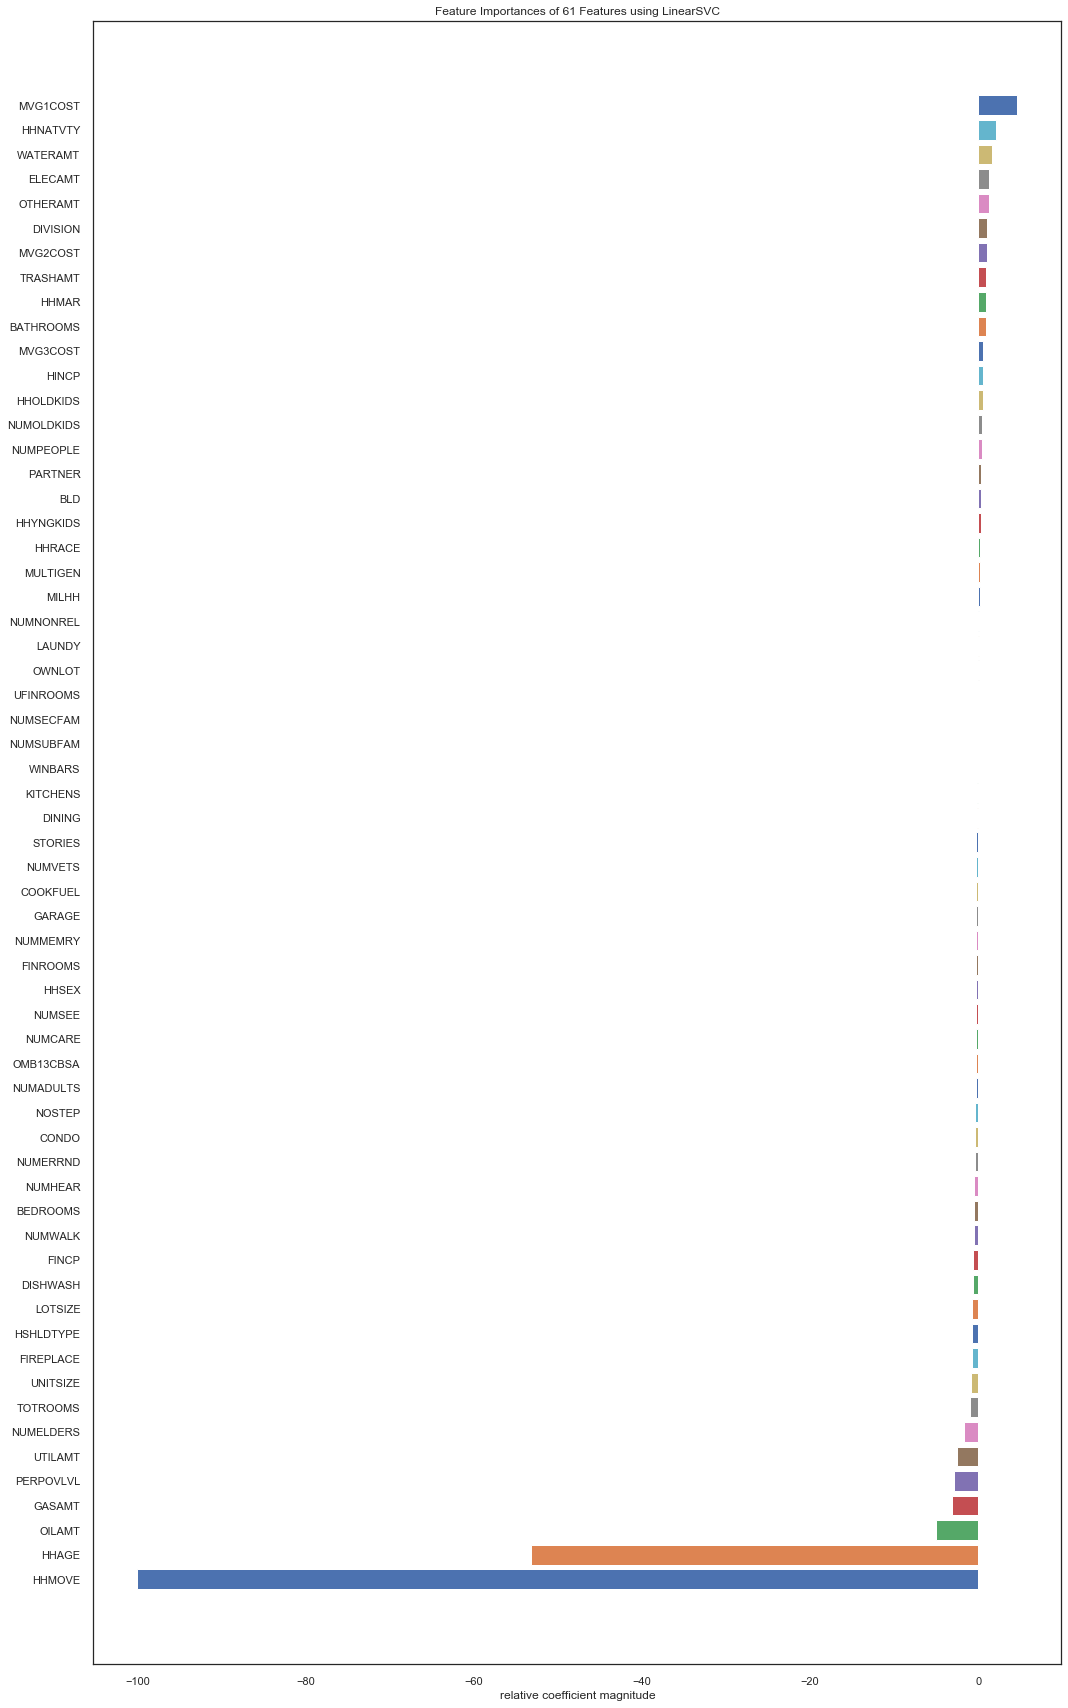

In [92]:
# Using LinearSVC model
from sklearn import svm
from yellowbrick.features import FeatureImportances

model = svm.LinearSVC()
viz = FeatureImportances(model, size=(1080, 1720))

viz.fit(X, y)
viz.show()

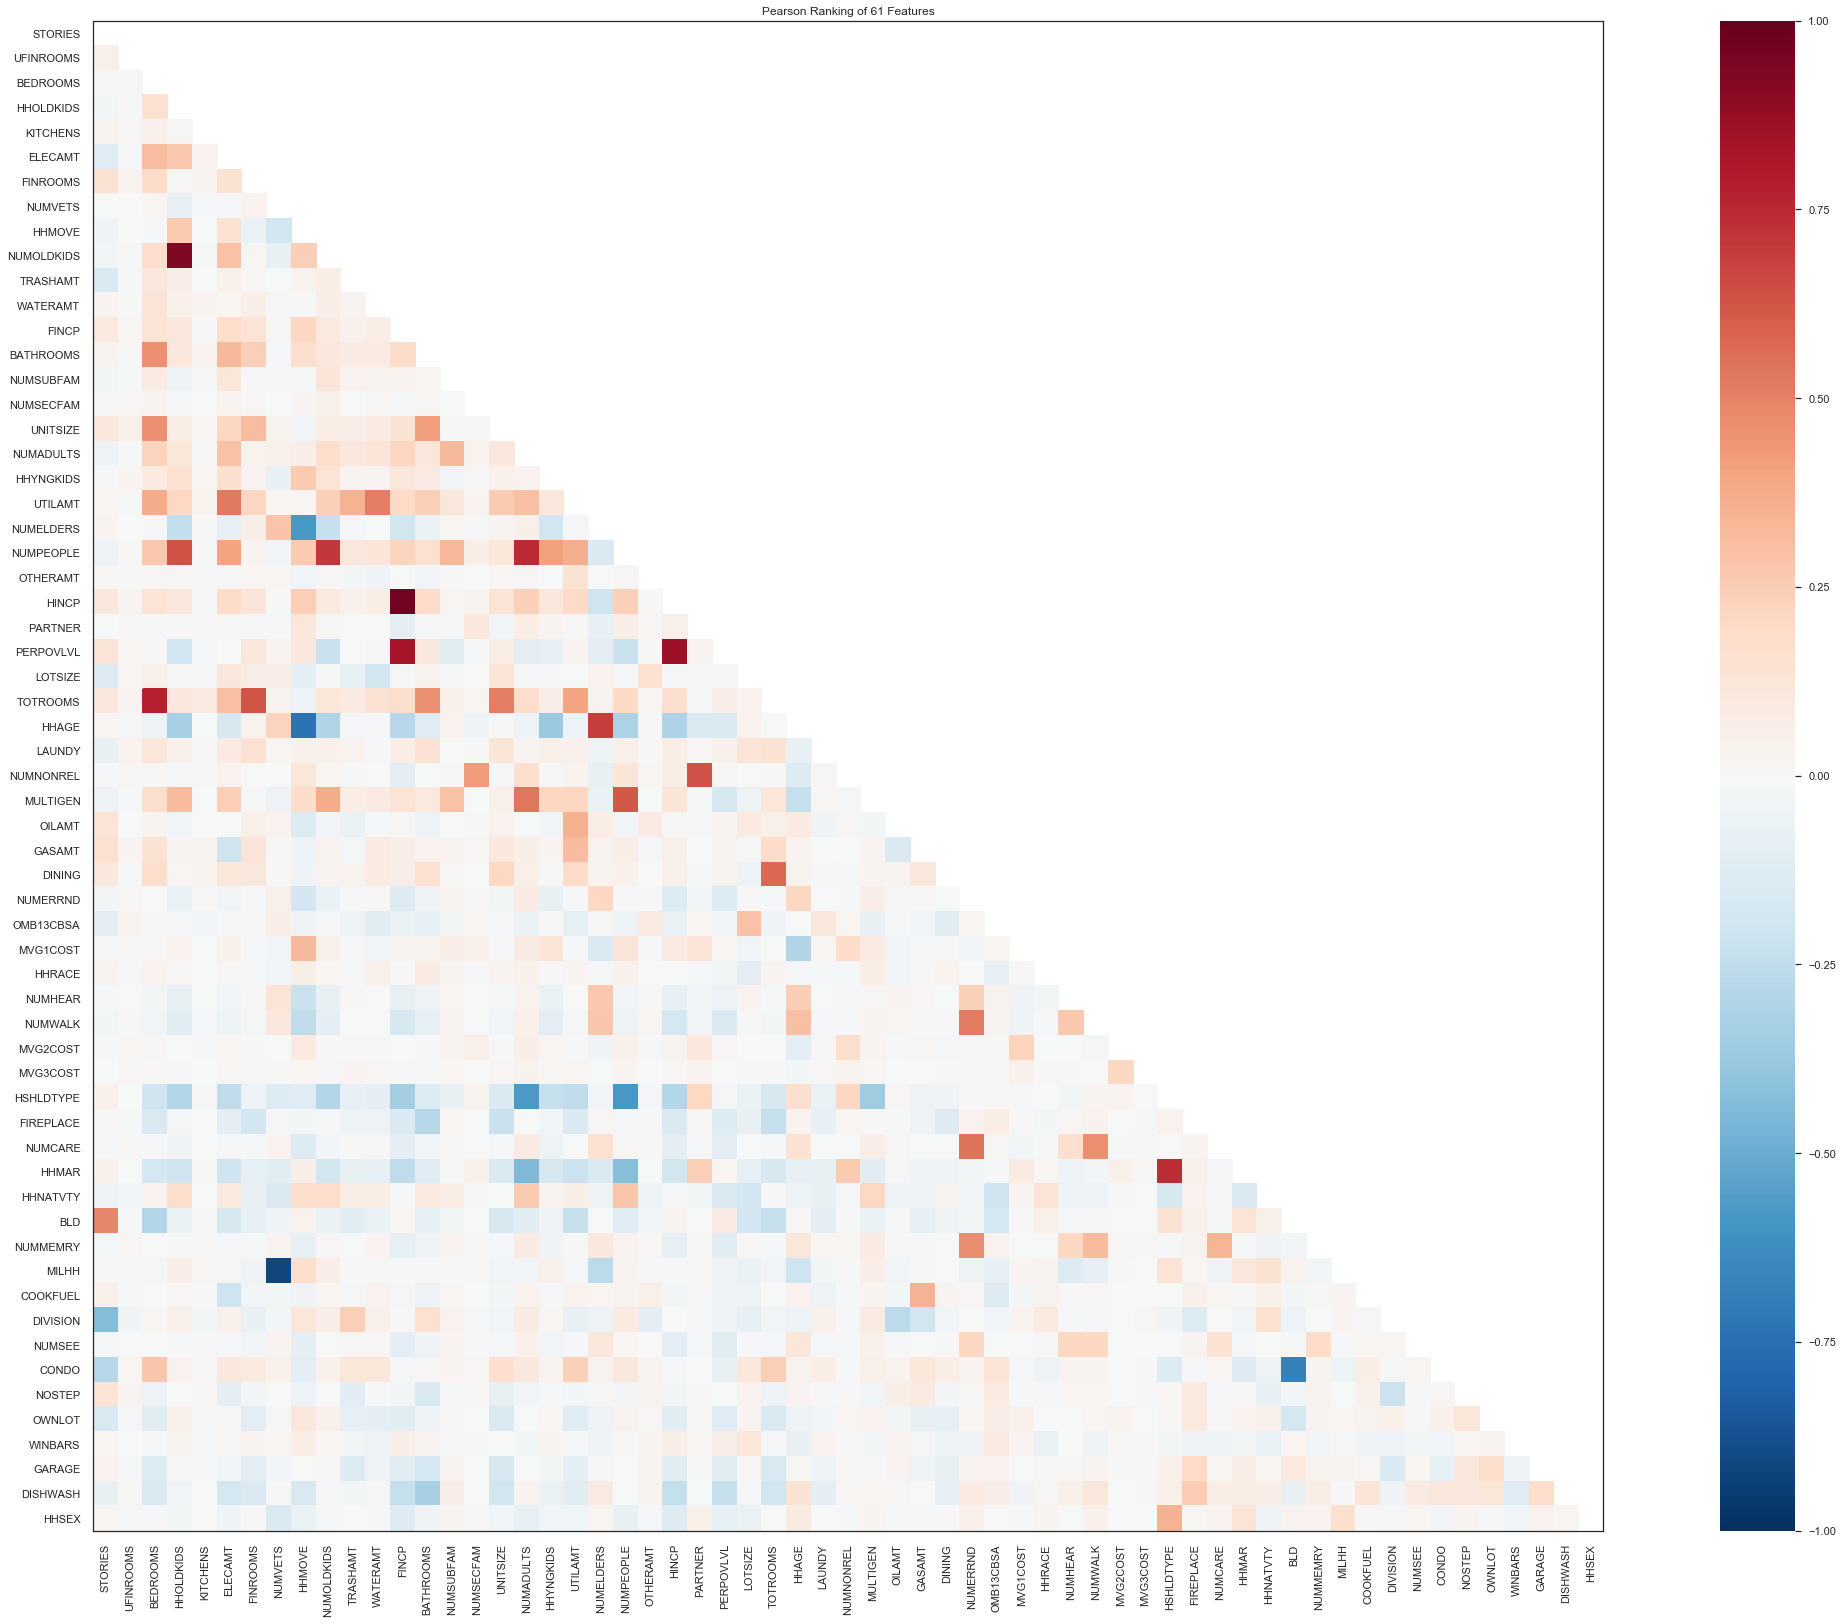

In [93]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(3000, 2000))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

### Correlation Matrix with Heatmap

In [112]:
df_corr=df[['HHAGE',  'FINCP', 'HINCP', 'BATHROOMS', 'UTILAMT','PERPOVLVL',  'ELECAMT', 
          'TRASHAMT', 'WATERAMT', 'TOTROOMS','OMB13CBSA','UNITSIZE','LOTSIZE', 'NUMPEOPLE','STORIES', 
'HHNATVTY','DIVISION', 'MVG3COST','HHOLDKIDS','HHMOVE', 'OILAMT', 'GASAMT']]

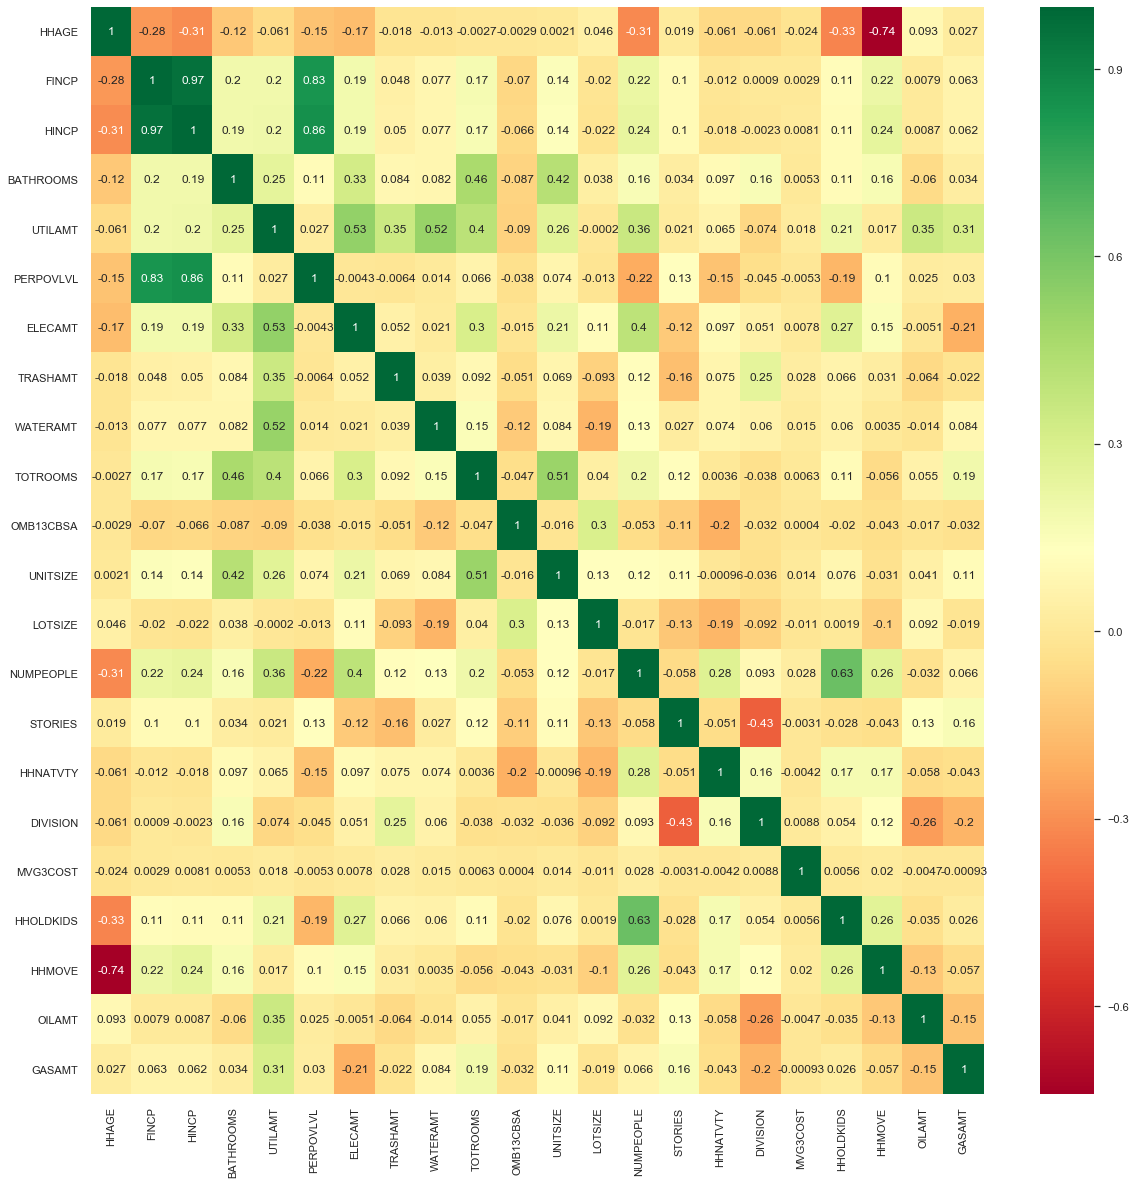

In [113]:
corrmat = df_corr.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_corr[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Feature Selection

In [114]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import ExtraTreesClassifier


In [115]:
features = df_corr
labels = target

In [116]:
model = LogisticRegression()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['HHAGE', 'BATHROOMS', 'ELECAMT', 'TOTROOMS', 'UNITSIZE', 'LOTSIZE']


In [117]:
model = RandomForestClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['HHAGE', 'FINCP', 'HINCP', 'UTILAMT', 'PERPOVLVL', 'ELECAMT', 'TRASHAMT', 'WATERAMT', 'HHMOVE', 'GASAMT']


In [118]:
model = SGDClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['HHAGE', 'UTILAMT', 'PERPOVLVL', 'ELECAMT', 'WATERAMT', 'HHNATVTY', 'OILAMT']


#### Based on the feature importance and SelectfromModel - top features are:
'HHAGE', 'HINCP', 'BATHROOMS', 'UTILAMT','PERPOVLVL',  'ELECAMT', 'GASAMT', 
          'TRASHAMT', 'WATERAMT', 'OMB13CBSA','UNITSIZE','NUMPEOPLE','STORIES', 
'HHNATVTY', 'MVG3COST'
        